# FAIR Jupyter Evaluation: Benchmark and Performance Metrics
FAIR Jupyter is a knowledge graph for semantic sharing and granular exploration of a computational notebook reproducibility dataset. This notebook provides some SPARQL queries to query the FAIR Jupyter SPARQL Endpoint. These SPARQL queries include queries that reproduce the original results, as well as additional queries that were not included in the [publication](https://doi.org/10.1093/gigascience/giad113). It also supports federated queries to external resources such as [Wikidata](https://query.wikidata.org/) and [MaRDI](https://www.mardi4nfdi.de).
More Information on FAIR Jupyter Ontology and Knowledge Graph: [https://w3id.org/fairjupyter](https://w3id.org/fairjupyter).

This notebook runs ten SPARQL queries on FAIR Jupyter and federated queries over Wikidata. It runs the notebook two times with different LIMITs. It logs the performance metrics when the queries are run with limit (e.g, 10, 100, 1000) and also logs the memory usage for each query execution.

## Prerequisites
The notebook is written in Python and besides Jupyter and Wikidata, it has the following direct dependencies:
* sparqlwrapper
* pandas
* matplotlib
* seaborn


In [1]:
!pip install sparqlwrapper

In [2]:
!pip install seaborn

In [3]:
!pip install matplotlib

In [4]:
import time
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SPARQL Endpoint

In [5]:
# Define the SPARQL endpoint
sparql = SPARQLWrapper("https://reproduceme.uni-jena.de/fairjupyter/sparql")

In [6]:
# Create results folder if not exists
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Selected SPARQL queries and federated queries over Wikidata and MaRDI

In [7]:
# List of queries with placeholders for LIMIT
queries = [
    """
    SELECT ?research_field (COUNT(DISTINCT ?article) AS ?number_of_articles)
    WHERE {{  
      ?repository <http://purl.org/pav/retrievedFrom> ?article .
      ?article <http://www.w3.org/ns/prov-o#specializationOf> ?mesh .
      ?mesh <http://www.w3.org/ns/prov-o#generalizationOf> ?top_mesh .
      ?top_mesh <http://www.w3.org/2000/01/rdf-schema#label> ?research_field
      
    }}
    GROUP BY ?research_field
    ORDER BY DESC(?number_of_articles)
    LIMIT {}
    """,
    """
    SELECT ?journal_name (COUNT(?article) as ?article_count)
    WHERE {{
      ?article <https://w3id.org/reproduceme/publishedIn> ?journal .
      ?journal <http://www.w3.org/2000/01/rdf-schema#label> ?journal_name .
    }}
    GROUP BY ?journal_name
    ORDER BY DESC(?article_count)
    LIMIT {}
    """,
    """
    SELECT ?language (COUNT(?notebook) as ?notebook_count)
    WHERE {{
      ?notebook a <https://w3id.org/reproduceme/Notebook> ;
                <https://w3id.org/reproduceme/language> ?language .
    }}
    GROUP BY ?language
    ORDER BY DESC(?notebook_count)
    LIMIT {}
    """,
    """
    SELECT ?exception (COUNT(?exception) AS ?count)
    WHERE {{
      ?execution  a <https://w3id.org/reproduceme/CellExecution> ;
        <https://w3id.org/reproduceme/exception> ?exception .
    }}
    GROUP BY ?exception
    ORDER BY DESC(?count)
    LIMIT {}
    """,
    """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    SELECT DISTINCT ?research_field (COUNT(?exception) AS ?exception_count)
    WHERE {{  
      ?execution  a <https://w3id.org/reproduceme/CellExecution> ;
        <https://w3id.org/reproduceme/exception> ?exception ;
        <http://purl.org/pav/retrievedFrom> ?repository .
      ?repository a <http://usefulinc.com/ns/doap#GitRepository> ;
      			<http://purl.org/pav/retrievedFrom> ?article ;
      			<https://w3id.org/reproduceme/notebooks_count> ?notebooks_count .
      ?article a <http://purl.org/spar/fabio/Article> ; 
      		 <http://www.w3.org/ns/prov-o#specializationOf> ?mesh .
      ?mesh <http://www.w3.org/ns/prov-o#generalizationOf> ?top_mesh .
      ?top_mesh <http://www.w3.org/2000/01/rdf-schema#label> ?research_field .    
      FILTER (xsd:integer(?notebooks_count)>0)
    }}
    GROUP BY ?research_field
    ORDER BY DESC(?exception_count)
    LIMIT {}
    """,
    """
    SELECT ?notebook ?error ?description
    WHERE {{
      ?error a <https://w3id.org/reproduceme/NotebookCodeStyleError> ;
            <https://w3id.org/reproduceme/description> ?description ;
            <http://purl.org/pav/retrievedFrom> ?notebook .
    }}
    LIMIT {}
    """,
    """
    SELECT DISTINCT ?article ?keywords WHERE {{ 
      ?article <https://w3id.org/reproduceme/keywords> ?keywords .
      FILTER (REGEX(LCASE(?keywords), "open(.)source"))
    }}
    LIMIT {}
    """,
    """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    SELECT DISTINCT ?repo ?stargazers_count WHERE {{
      ?repo <https://w3id.org/reproduceme/stargazers_count> ?count. 
      BIND(xsd:float(?count) AS ?stargazers_count)
      FILTER ((?stargazers_count) > 0)
    }}
    ORDER BY DESC(?stargazers_count)
    LIMIT {}
    """,
    """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    PREFIX wikidata_wd: <http://www.wikidata.org/entity/>
    PREFIX wikidata_wdt: <http://www.wikidata.org/prop/direct/>
    
    SELECT DISTINCT
    
     ?fj_article
     ?wikidata
     ?wikidata_label
     ?DOI
    
    WHERE {{
      ?fj_article <https://w3id.org/reproduceme/doi> ?doi .
      BIND(UCASE(?doi) AS ?DOI)
      service <https://query.wikidata.org/sparql> {{
        ?wikidata wikidata_wdt:P356 ?DOI .
        ?wikidata rdfs:label ?wikidata_label .
        FILTER (LANG(?wikidata_label) = "en")
      }}
    }}
    LIMIT {}
    """,
    """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    PREFIX mardi_wd: <https://portal.mardi4nfdi.de/entity/>
    PREFIX mardi_wdt: <https://portal.mardi4nfdi.de/prop/direct/>
    
    PREFIX bd: <http://www.bigdata.com/rdf#>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    
    SELECT DISTINCT ?title ?doi ?method ?methodLabel
    
    WHERE {{
      ?fj_article <https://w3id.org/reproduceme/doi> ?doi .
    
      service <http://query.portal.mardi4nfdi.de/proxy/wdqs/bigdata/namespace/wdq/sparql> {{
        ?mardi_paper mardi_wdt:P27 ?doi .
        ?mardi_paper mardi_wdt:P159 ?title .
        
        ?mardi_paper mardi_wdt:P1463 ?method .
        ?method rdfs:label ?methodLabel .
      }}
    
    }}
    LIMIT {}
    """,
]


# Functions

In [8]:
# Function to execute the SPARQL query and manually measure memory
def execute_query(query, limit):
    query_with_limit = query.format(limit)
    
    # Measure memory and time
    start_time = time.time()
    process = psutil.Process()  # Get current process
    mem_before = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    sparql.setQuery(query_with_limit)
    sparql.setReturnFormat(JSON)
    sparql.query().convert()
    
    mem_after = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    end_time = time.time()
    
    execution_time = end_time - start_time
    memory_used = mem_after - mem_before
    
    return execution_time, memory_used

In [9]:
# Function to run all queries for a specific LIMIT and log time/memory
def run_queries_with_limit(limit):
    results = []
    total_start_time = time.time()
    total_mem_usage = []

    for i, query in enumerate(queries):
        print(f"Running Query {i+1} with LIMIT {limit}...")
        
        # Run the query and log time/memory
        execution_time, mem_usage = execute_query(query, limit)        
        print(f"Execution Time (s): {execution_time}")
        print(f"Memory Usage (MB): {mem_usage}")
        time.sleep(2)  # Delay for 2 seconds between queries
        
        if execution_time is not None and mem_usage is not None:
            total_mem_usage.append(mem_usage)
            results.append({
                'Query': i + 1,
                'LIMIT': limit,
                'Execution Time (s)': execution_time,
                'Memory Usage (MB)': mem_usage
            })
        else:
            print(f"Skipping Query {i+1} due to an error.")
    
    total_end_time = time.time()
    total_execution_time = total_end_time - total_start_time
    total_memory_usage = max(total_mem_usage) if total_mem_usage else None  # Overall peak memory usage
    
    # Log the total memory/time for the whole notebook
    results.append({
        'Query': 'Total',
        'LIMIT': limit,
        'Execution Time (s)': total_execution_time,
        'Memory Usage (MB)': total_memory_usage
    })
    
    return results

# Results

In [10]:

# Run the notebook two times with different LIMITs
all_results = []
for limit in [10, 100, 1000]:
    run_results = run_queries_with_limit(limit)
    all_results.extend(run_results)

# Save results to a DataFrame and export to CSV
df_results = pd.DataFrame(all_results)
# Construct the full CSV file path inside the results folder
csv_filename = "sparql_benchmark_results"
csv_file = os.path.join(results_folder, csv_filename + '.csv')
df_results.to_csv(csv_file, index=False)

print("Benchmarking complete. Results saved to {}.".format(csv_file))


Running Query 1 with LIMIT 10...
Execution Time (s): 4.211550235748291
Memory Usage (MB): 1.5
Running Query 2 with LIMIT 10...
Execution Time (s): 1.0972840785980225
Memory Usage (MB): 0.0
Running Query 3 with LIMIT 10...
Execution Time (s): 1.071873664855957
Memory Usage (MB): 0.125
Running Query 4 with LIMIT 10...
Execution Time (s): 0.7322406768798828
Memory Usage (MB): 0.0
Running Query 5 with LIMIT 10...
Execution Time (s): 1.410151481628418
Memory Usage (MB): 0.0
Running Query 6 with LIMIT 10...
Execution Time (s): 0.5455341339111328
Memory Usage (MB): 0.0
Running Query 7 with LIMIT 10...
Execution Time (s): 0.6747770309448242
Memory Usage (MB): 0.0
Running Query 8 with LIMIT 10...
Execution Time (s): 0.4180607795715332
Memory Usage (MB): 0.0
Running Query 9 with LIMIT 10...
Execution Time (s): 1.7246513366699219
Memory Usage (MB): 0.0
Running Query 10 with LIMIT 10...
Execution Time (s): 38.858741998672485
Memory Usage (MB): 0.0
Running Query 1 with LIMIT 100...
Execution Time (

Plot has been saved in results/sparql_benchmark_results.pdf


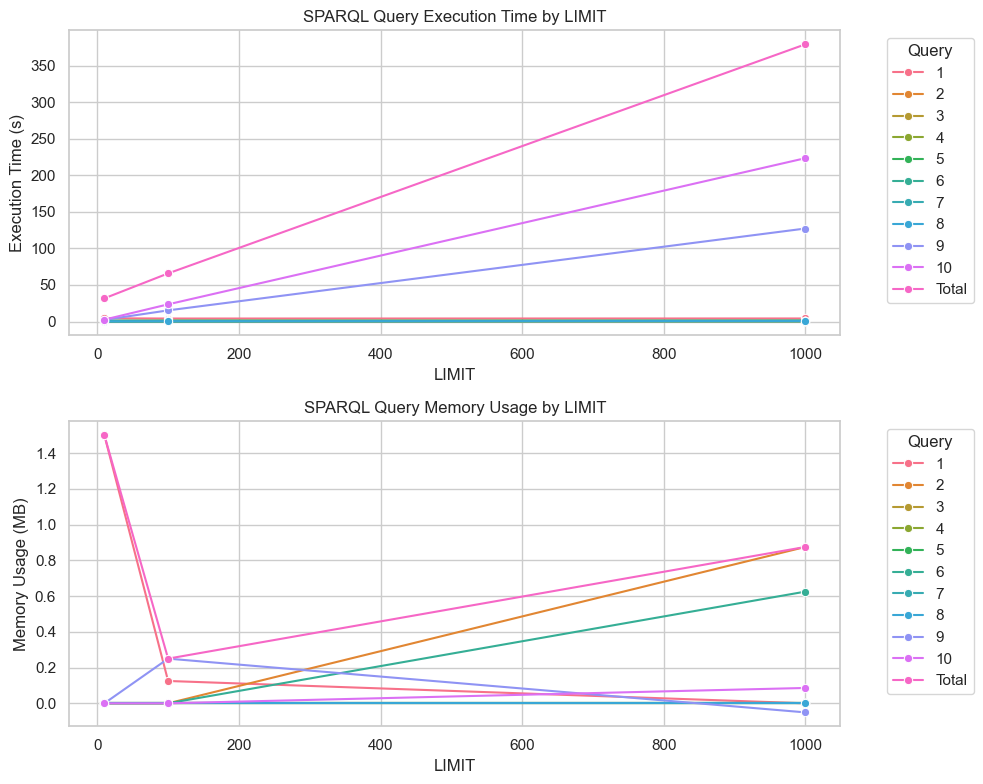

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the benchmark results from the CSV file
df_results = pd.read_csv('sparql_benchmark_results.csv')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create a figure with two subplots: one for execution time, one for memory usage
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Execution Time
sns.lineplot(
    data=df_results, 
    x='LIMIT', 
    y='Execution Time (s)', 
    hue='Query', 
    marker="o", 
    ax=axs[0]
)
axs[0].set_title('SPARQL Query Execution Time by LIMIT')
axs[0].set_ylabel('Execution Time (s)')
axs[0].set_xlabel('LIMIT')
axs[0].legend(title='Query', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Memory Usage
sns.lineplot(
    data=df_results, 
    x='LIMIT', 
    y='Memory Usage (MB)', 
    hue='Query', 
    marker="o", 
    ax=axs[1]
)
axs[1].set_title('SPARQL Query Memory Usage by LIMIT')
axs[1].set_ylabel('Memory Usage (MB)')
axs[1].set_xlabel('LIMIT')
axs[1].legend(title='Query', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Construct the full CSV file path inside the results folder
results_filename = "sparql_benchmark_results"
results_file = os.path.join(results_folder, results_filename + '.pdf')

# Save the figure as a PDF
fig.savefig(results_file)

print("Plot has been saved in {}".format(results_file))

plt.show()
